# Лабораторная работа "Фемптосекундный  лазер"

## В  настоящем блокноте представлена  программа для  выполнения следующих задач:<br>
### 1)Определяете период следования и частоту повторений импульсов лазера  
### 2)Определяете время наростания фронта импульсов от 10% до 90% на обоих фотоприёмниках
### 3)Привести спектр и описать его, определить ширину спектра 
### 4)Привести среднюю мощность на выходе из лазера и кристалла, определить эффективность преобразования во 2 гармонику 
### 5)Проверить, является ли импульс спектрально ограниченным
### 6)Оценить энергию в одном импульсе
### 7)Посчитать пиковую мощность 
### 8)Посчитать пиковую интенсивность при фокусировке импульса в пятно диаметром 8 мкм

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.signal import argrelextrema
from scipy.signal import find_peaks, peak_widths,savgol_filter
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import copy
import math
from scipy.stats import t

In [4]:
data_path =  "femtosecond_laser_lab_data"
save_path = "results"

In [78]:
c = 3*10**8 # скорость света

In [53]:
def unpack(path, mod): 
    file = open(path + "\\" + mod + ".txt", 'r' )
    data = file.readlines()
    data = [line.rstrip().replace("\t",',').split(",") for line in data]
    settings = data[:4]
    del data[:5]
    del data[-1]
    data = np.array(data).astype('float')
    time = data[:,0]
    signal = data[:, 1]
    return  settings, time, signal

def unpack1(path, mod): 
    file = open(path + "\\" + mod + ".DAT", 'r' )
    data = file.readlines()
    data = [line.rstrip().replace("\t",',').split(",") for line in data]
    settings = data[:7]
    del data[:7]
    del data[-1]
    data = np.array(data).astype('float')
    time = data[:,0]
    signal = data[:, 1]
    return  settings, time, signal

def find_max(data, prominence, distance):
    max_ind = find_peaks(data[1],  prominence =  prominence, distance = distance)
    return [data[0][max_ind[0]],data[1][max_ind[0]], max_ind[0]]

def rand_error(data):
    mean = np.mean(data)
    n = len(data)
    #Доверительная вероятность  
    conf_prob = 0.66 
    student_coef = round(t.ppf((1 + conf_prob )/2, n - 1), 2)
    var = np.var(data)
    interval = student_coef * math.sqrt((var)/n)
    return [mean, interval]
 

In [13]:
settings, time, signal  =  unpack(data_path, "period")

## 1)Определяете период следования и частоту повторений импульсов лазера 

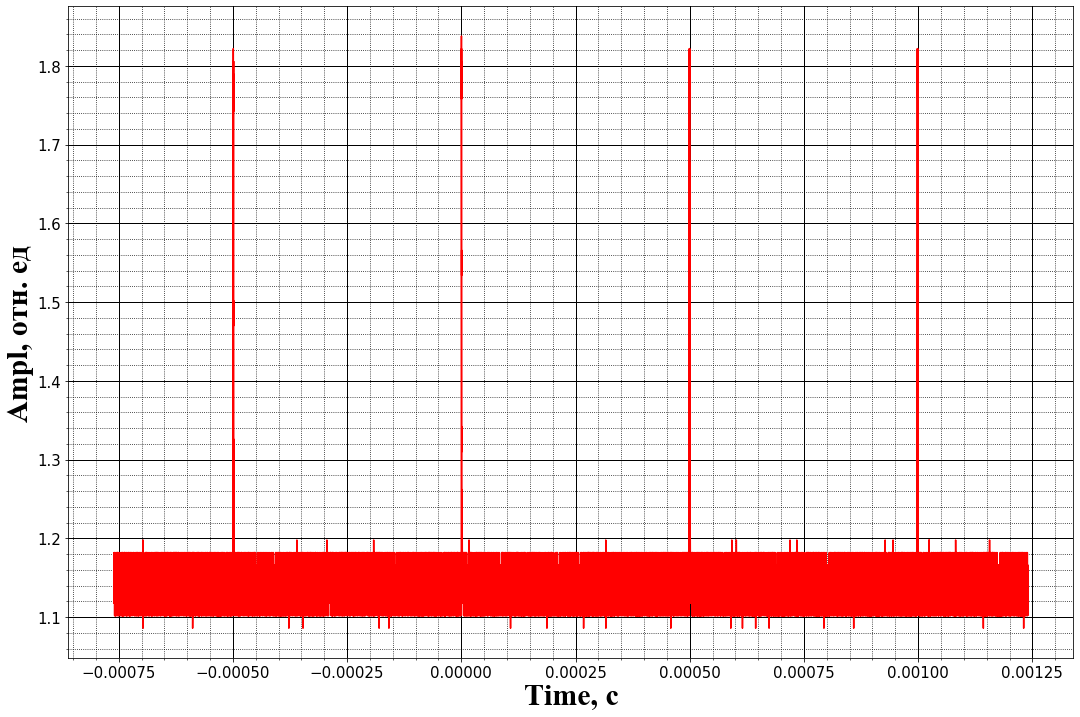

In [26]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(time,  signal, c = 'r') 
ax.set_xlabel('Time, c',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.set_ylabel("Ampl, отн. ед",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=15)
ax.minorticks_on()

#  Определяем внешний вид линий основной сетки:
ax.grid(which='major',
        color = 'k', 
        linewidth = 1)

#  Определяем внешний вид линий вспомогательной
#  сетки:
ax.grid(which='minor', 
        color = 'k', 
        linestyle = ':')

In [41]:
Max_int_index = find_peaks(signal, 1.82)
print(Max_int_index)
Max_indices = [130474, 380162, 629890, 879267] # Найдено ручным спосом(перебором точек максимума)

(array([130474, 380062, 380098, 380162, 380246, 629638, 629890, 879202,
       879214, 879238, 879267, 879291, 879354], dtype=int64), {'peak_heights': array([1.82196, 1.82196, 1.82196, 1.83796, 1.82196, 1.82196, 1.82196,
       1.82196, 1.82196, 1.82196, 1.82196, 1.82196, 1.82196])})


In [48]:
Period_list = np.diff([time[i] for i in Max_indices])
print(Period_list)
Period_error = rand_error(Period_list)
Period, Delta_Period, delta_Period = Period_error[0], Period_error[1], Period_error[1]*100/Period_error[0]
print(Period, Delta_Period, delta_Period)

[0.00049938 0.00049946 0.00049875]
0.0004991953333333333 2.2463541861795385e-07 0.0449995029236292


Период следования импульсов равен:
$Т_{pulse}$ = (4992$\pm$2)*10^-7 c              $\delta{T}$ = 0.05%

In [49]:
Frequency_pulse, Delta_Frequency, delta_Frequency = 1/Period, delta_Period/(100*Period), delta_Period
print(Frequency_pulse, Delta_Frequency, delta_Frequency)

2003.2238549238577 0.9014407771632988 0.0449995029236292


$\nu_{pulse}$ = (20032$\pm$9)*10^-1 Гц $\delta{\nu}$ = 0.05%

# Третье задание 
## Измерение спектра по спектрометру

In [57]:
settings_spectrum, wavelenght, Signal_spectrum  =  unpack1(data_path, "spectrum")

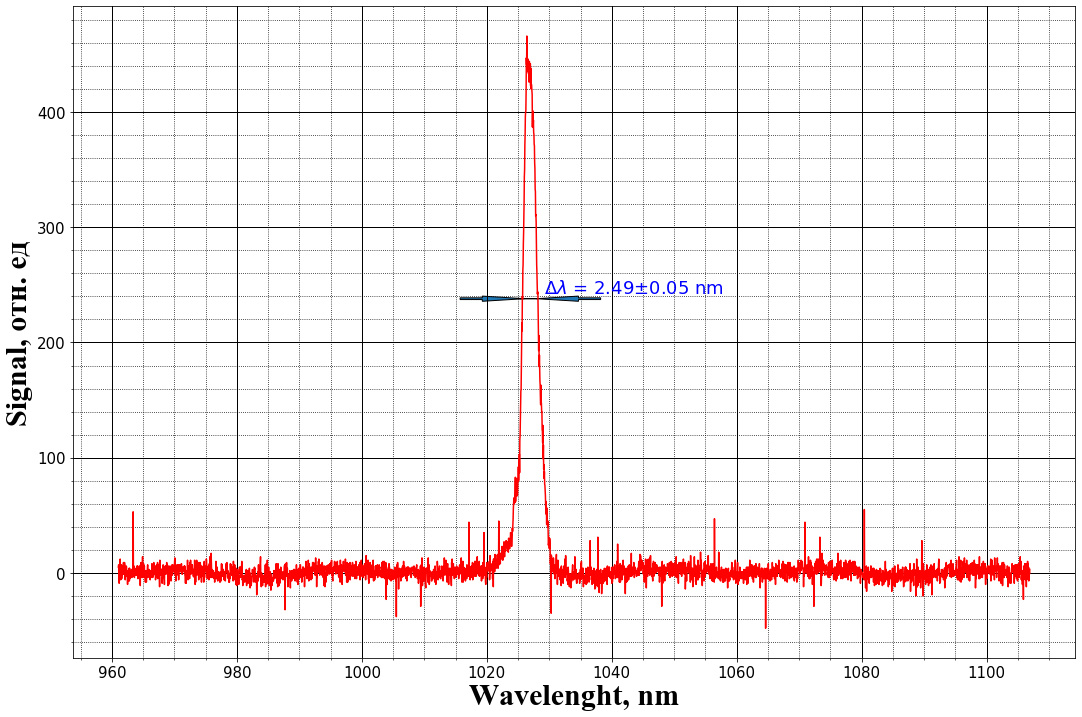

In [105]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(wavelenght, Signal_spectrum, c = 'r') 
ax.set_xlabel('Wavelenght, nm',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.set_ylabel("Signal, отн. ед",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.arrow(wavelenght[1601]-10, Signal_spectrum[1601], 3.55, 0, width = 1.5 )
ax.arrow(wavelenght[1663]+10, Signal_spectrum[1601], -3.55, 0, width = 1.5 )
ax.arrow(wavelenght[1663], Signal_spectrum[1601], -3, 0)
plt.annotate('$\Delta{\lambda}$ = 2.49$\pm$0.05 nm', xy = (wavelenght[1663] +1, Signal_spectrum[1601]+5), fontsize = 18,color = 'b' )
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=15)
ax.minorticks_on()

#  Определяем внешний вид линий основной сетки:
ax.grid(which='major',
        color = 'k', 
        linewidth = 1)

#  Определяем внешний вид линий вспомогательной
#  сетки:
ax.grid(which='minor', 
        color = 'k', 
        linestyle = ':')

In [72]:
for i in range(len(Signal_spectrum)): # Ручным способом нашел индексы отвечающие высоте 0.5*max, это оказались индексы [1601,1663]
    if Signal_spectrum.max()/2 - 8 <= Signal_spectrum[i] <= Signal_spectrum.max()/2 + 8 :
        print(i) # вывожу индексы длин волн удовлетворяющие условию полувысоты, извините за прямолинейность, np.where пощему-то не работало...

1600
1601
1663


In [62]:
wavelenght_main = wavelenght[np.where(Signal_spectrum == Signal_spectrum.max())] #длина волны, отвечающая пику импульса 
wavelenght_main

array([1026.41])

In [74]:
Delta_wavelenght_main = wavelenght[1663] - wavelenght[1601] # ширина импульса на полувысоте
Delta_wavelenght_main 

2.490000000000009

Посчитаем погрешности для длин волн, они будут исходить из погрешности спектрометра по оси абсцисс(длина волны), деление 0.04 nm и из погрешности спектрометра по оси ординат( выбор уровня 0.5 от высоты)

In [75]:
delta_ordinate = 1/(Signal_spectrum.max()/2)*100 # погрешность ось ординат
delta_ordinate

0.4291845493562232

In [76]:
delta_abscissa = 0.04/Delta_wavelenght_main*100 # погрешность ось абсцисс
delta_abscissa

1.6064257028112392

In [77]:
delta_Delta_wavelenght_main = np.sqrt(delta_ordinate**2 + delta_abscissa**2)
delta_Delta_wavelenght_main 

1.66276965213426

$\lambda_{0}$ = 1026 $\pm$ 21 nm

$\Delta{\lambda}$ = 2.49$\pm$0.05 nm

$\delta{\Delta{\lambda}}$ = 2%

In [80]:
frequency_main, delta_frequency = c/wavelenght_main, c*(1/(wavelenght_main - Delta_wavelenght_main/2) - 1/(wavelenght_main + Delta_wavelenght_main/2))
Delta_delta_frequency = delta_frequency*delta_Delta_wavelenght_main/100
frequency_main, delta_frequency, Delta_delta_frequency

(array([292280.8624234]), array([709.05429429]), array([11.78993962]))

$\nu_{0}$ = (292 $\pm$ 6) ТГц

$\Delta{\nu}$ = 709$\pm$14 ГГц

$\delta{\Delta{\nu}}$ = 2%

## Четвертое задание
### Привести среднюю мощность на выходе из лазера и кристалла, определить эффективность преобразования во 2 гармонику 

In [111]:
P_list_before = [104.4, 104.3, 102.9, 101.1, 103.1, 103.2]
P_list_after = [33.19, 31.55, 33.53, 34.76, 34.19, 34.31]
P_list_before_errors = rand_error(P_list_before)
P_list_after_errors = rand_error(P_list_after)
P_first_harmonic, Delta_P_first_harmonic, delta_P_first_harmonic = P_list_before_errors[0], P_list_before_errors[1], P_list_before_errors[1]/P_list_before_errors[0]*100
print(P_first_harmonic, Delta_P_first_harmonic, delta_P_first_harmonic)
P_second_harmonic, Delta_P_second_harmonic, delta_P_second_harmonic = P_list_after_errors[0], P_list_after_errors[1], P_list_after_errors[1]/P_list_after_errors[0]*100
print(P_second_harmonic, Delta_P_second_harmonic, delta_P_second_harmonic)
conversion_efficiency = P_second_harmonic/P_first_harmonic*100
delta_conversion_efficiency = np.sqrt(delta_P_first_harmonic**2 + delta_P_second_harmonic**2)
Delta_conversion_efficiency = conversion_efficiency*delta_conversion_efficiency/100
print(conversion_efficiency, Delta_conversion_efficiency, delta_conversion_efficiency)

103.16666666666669 0.46805003293807623 0.4536833921855343
33.58833333333333 0.4486449621731344 1.3357166541154204
32.5573505654281 0.4592742098122797 1.410662114195411


$P_{1}~=~103.2\pm0.5~~мВт~~\delta{P_{1}} = 0.5$%

$P_{2}~=~33.6\pm0.5~~мВт~~\delta{P_{1}} = 1.3$%

$Ef~=~32.6\pm0.5$%$~~\delta{P_{1}} = 1.4$%

# Шестое-Седьмое-Восьмое задание
## Оценить энергию в одном импульсе
Так как мы измерили период следования импульса $Т_{pulse}$ = (4992$\pm$2)*10^-7 c, Среднюю мозщность импульса $P_{1}~=~103.2\pm0.5~~мВт$, а также "измерили" длительность импульса с помощью автокоррелятора $t_{pulse}~=~288.4\pm20.9~~фс$

In [116]:
t_pulse = 288.4*10**-15
Delta_t_pulse = 20.9*10**-15
delta_t_pulse = Delta_t_pulse/t_pulse*100

In [115]:
E_pulse = Period*P_first_harmonic 
Delta_E_pulse = Period*Delta_P_first_harmonic + P_first_harmonic*Delta_Period #расчет погрешности косвенной величены
delta_E_pulse = Delta_E_pulse/E_pulse*100
print(E_pulse, Delta_E_pulse, delta_E_pulse)

0.05150031855555556 0.0002568232795632862 0.49868289510916347


$E_{pulse}~=~51.5\pm0.3~мкДж~~~~~\delta{E_{pulse}}~=~0.5$%

## Оценить пиковую мощность
Имея энергию в одном импульсе и, зная его длительность, нетрудно сосчитать пиковую мощность импульса, как отношение этих величин 

In [119]:
P_peak = E_pulse/t_pulse
Delta_P_peak = Delta_E_pulse/t_pulse +  E_pulse/t_pulse*delta_t_pulse/100 #расчет погрешности косвенной величены
delta_P_peak = Delta_P_peak/P_peak*100
print(P_peak/10**9, Delta_P_peak/10**9, delta_P_peak)

178.57253313299432 13.831446678373325 7.745562229367138


$P_{peak}~=~180\pm14~~ГВт~~~~\delta{P_{peak}}~=~8$%

## Оценить пиковую интенсивность
Имеется пиковая мощность и диаметр пучка. Пиковую интенсивность будем искать в виде отношения мощности импульса на площадь поперечного сечения пучка

In [120]:
d_beam = 8*10**-6

In [122]:
I_peak = P_peak*4/(3.14*d_beam**2)
Delta_I_peak = I_peak*delta_P_peak/100
delta_I_peak = delta_P_peak
print(I_peak, Delta_I_peak, delta_I_peak)

3.554389592615333e+21 2.7530745777016973e+20 7.745562229367138


$I_{peak}~=~(36\pm3)*10^{20}~~Вт/м^2~~~~\delta{I_{peak}}~=~8$%

## Оценить является ли импульс спектрально ограниченным 
Рассмотрим величины такие, как спетральную ширину импульса $\Delta{\nu}$ = 709$\pm$14 ГГц и длительность импульса $t_{pulse}~=~288.4\pm20.9~~фс$. Они связаны через коэффициент квадрата гиперболического секанса (sech2), что соответствует величине k=0,315. Проверим насколько наши значения далеки от теоретических сведений.

In [124]:
k = t_pulse*delta_frequency*10**9
Delta_k = Delta_t_pulse*delta_frequency*10**9 + t_pulse*Delta_delta_frequency*10**9
delta_k = Delta_k/k*100
print(k, Delta_k, delta_k )

[0.20449126] [0.01821945] [8.90964899]


$k = 0.205\pm0.018~~~~~\delta{k}~=~9$%  $k_{табличное} = 0.315$ -- не совпадает нихуя- ну и похуй, значит их теория хуйня